# B Point Plotting Example

This notebook demonstrates running a B-point extraction (Pale et al., 2021) on the example dataset and several
plotting styles: low-level plotting, split/zoomed axes, showing reference points, detected points, and heartbeat borders.

## Setup and imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from fau_colors import cmaps

from pepbench.example_data import get_example_dataset
from pepbench.algorithms.icg import CPointExtractionScipyFindPeaks, BPointExtractionPale2021
from pepbench.plotting.algorithms import plot_b_point_extraction_pale2021

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Plotting style

In [2]:
plt.close("all")
palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)
plt.rcParams['figure.figsize'] = (10, 4)


## Load example dataset using get_example_dataset()

In [3]:
# This will download the example zip automatically if it's not present locally
dataset = get_example_dataset(return_clean=True)
dataset


,participant
0,VP_001
1,VP_002


### Pick the first available participant/phase from the example dataset

In [4]:
print('Dataset index (first rows):')
display(dataset.index.head(10))

row = dataset.index.iloc[0]
participant, condition, phase = row['participant'], row.get('condition', None), row.get('phase', None)
print('Using:', participant, condition, phase)

# create a datapoint subset for this entry
datapoint = dataset.get_subset(participant=participant)
datapoint


Dataset index (first rows):


,participant
0,VP_001
1,VP_002


Using: VP_001 None None


,participant
0,VP_001


## Run the algorithms (C-point then B-point) on the datapoint

In [5]:
# C-point extraction (used by Pale et al. B-point algorithm)
c_algo = CPointExtractionScipyFindPeaks()
c_algo.extract(icg=datapoint.icg,
               heartbeats=datapoint.heartbeats,
               sampling_rate_hz=datapoint.sampling_rate_icg)

# B-point extraction (Pale et al. 2021)
b_algo = BPointExtractionPale2021()
b_algo.extract(
    icg=datapoint.icg,
    heartbeats=datapoint.heartbeats,
    c_points=c_algo.points_,
    sampling_rate_hz=datapoint.sampling_rate_icg,
)


# show detected points table (head)
display(b_algo.points_.head())


,b_point_sample,nan_reason
heartbeat_id,,
0,179,NaN
1,533,NaN
2,1009,NaN
3,1466,NaN
4,1873,NaN


## 1) High-level helper plot (recommended)
Use the provided plotting helper `plot_b_point_extraction_pale2021` to visualise multiple heartbeats with
reference labels, detected C/B points and heartbeat borders.

In [6]:
datapoint.heartbeats.index.min()

np.int64(0)

Plotting heartbeat ids: [0, 1, 2, 3, 4]


ValueError: attempt to get argmin of an empty sequence

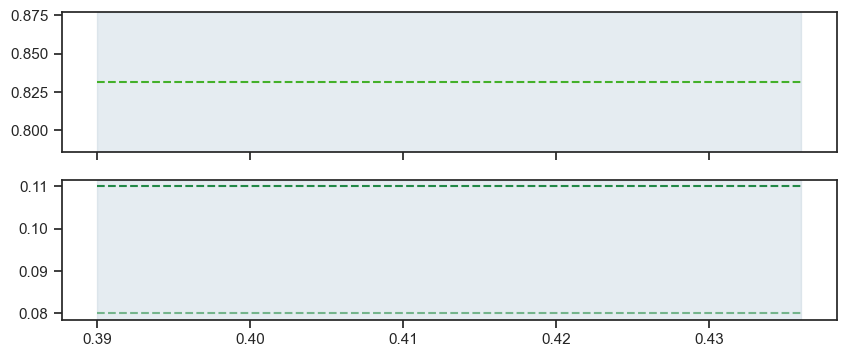

In [7]:
hb_ids = datapoint.heartbeats.index.get_level_values('heartbeat_id').unique()[:5].tolist()
print('Plotting heartbeat ids:', hb_ids)
fig, ax = plot_b_point_extraction_pale2021(datapoint, heartbeat_subset=hb_ids, normalize_time=True)

## 2) Low-level plotting: raw ICG with detected & reference markers and heartbeat borders

In [ ]:
# plot raw ICG and overlay reference/detected B-points and heartbeat borders
fig, ax = plt.subplots(figsize=(20, 5))
icg = datapoint.icg.squeeze()
ax.plot(icg.index, icg.values, label='ICG (preprocessed)')

# detected b points (from algorithm result)
b_samples = b_algo.points_['b_point_sample'].dropna().astype(int)
ax.scatter(icg.index[b_samples], icg.values[b_samples], color='C1', marker='o', label='Detected B')

# reference b points if available
try:
    ref_b = datapoint.reference_labels_icg.reindex(['ICG'], level='channel')['sample_relative']
    ref_b = ref_b.droplevel(['channel']).astype(int)
    ax.scatter(icg.index[ref_b], icg.values[ref_b], color='C2', marker='X', label='Reference B')
except Exception:
    pass

# heartbeat borders (start samples)
hb_borders = datapoint.heartbeats
ax.vlines(icg.index[hb_borders['start_sample']], ymin=icg.min(), ymax=icg.max(), colors='C3', linestyles='--', alpha=0.6, label='Heartbeat borders')

ax.legend(loc='upper right')
ax.set_title('Raw ICG with detected and reference B-points')
plt.show()


## 4) Show heartbeat borders and annotations using plotting utilities
Use the internal plotting utilities to add heartbeat borders and legend handling.

In [ ]:
from pepbench.plotting._utils import _add_heartbeat_borders, _add_icg_b_points, _add_pep_from_reference

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(icg.index, icg.values, label='ICG')
# heartbeat borders (use utility)
_add_heartbeat_borders(datapoint.heartbeats, ax)
# add detected B points using internal helper
_add_icg_b_points(datapoint.icg.squeeze(), b_samples, ax)
# add reference PEP spans if available
try:
    _add_pep_from_reference(datapoint.ecg, datapoint.icg, datapoint.reference_labels_ecg.join(datapoint.reference_labels_icg), ax, pep_hatch=None)
except Exception:
    pass
ax.set_title('ICG with heartbeat borders and annotations')
ax.legend()
plt.show()
